<a href="https://www.kaggle.com/code/georgistan/titanic-classification?scriptVersionId=173220978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
print(train.head)
print(train.info())
print(train.describe())

<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                     

- Look at the categorical data.

In [4]:
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


- How group by's impact the survival rate?

In [5]:
train.groupby(['Pclass'], as_index = False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train.groupby(['Sex'], as_index = False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train.groupby(['SibSp'], as_index = False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
train.groupby(['Parch'], as_index = False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [9]:
# family size on the titanic; plus 1 for the passenger themselves
# sibsp - no. of siblings/spouses
# parch - no. of parents/children

train['Family_size'] = train['SibSp'] + train['Parch'] + 1
test['Family_size'] = test['SibSp'] + test['Parch'] + 1

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


- The larger the family, the more the likelihood of survival decreases:

In [11]:
train.groupby(['Family_size'], as_index = False)['Survived'].mean()

,Family_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [12]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: "Large", 8: "Large", 11: "Large"}

train['Family_size_grouped'] = train['Family_size'].map(family_map)
test['Family_size_grouped'] = test['Family_size'].map(family_map)

train.groupby(['Family_size_grouped'], as_index = False)['Survived'].mean()

,Family_size_grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


In [13]:
train.groupby(['Embarked'], as_index = False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


- C has a much higher survival than S and Q (passengers embarking from Cherbourg compared to Southampton and Queenstown).

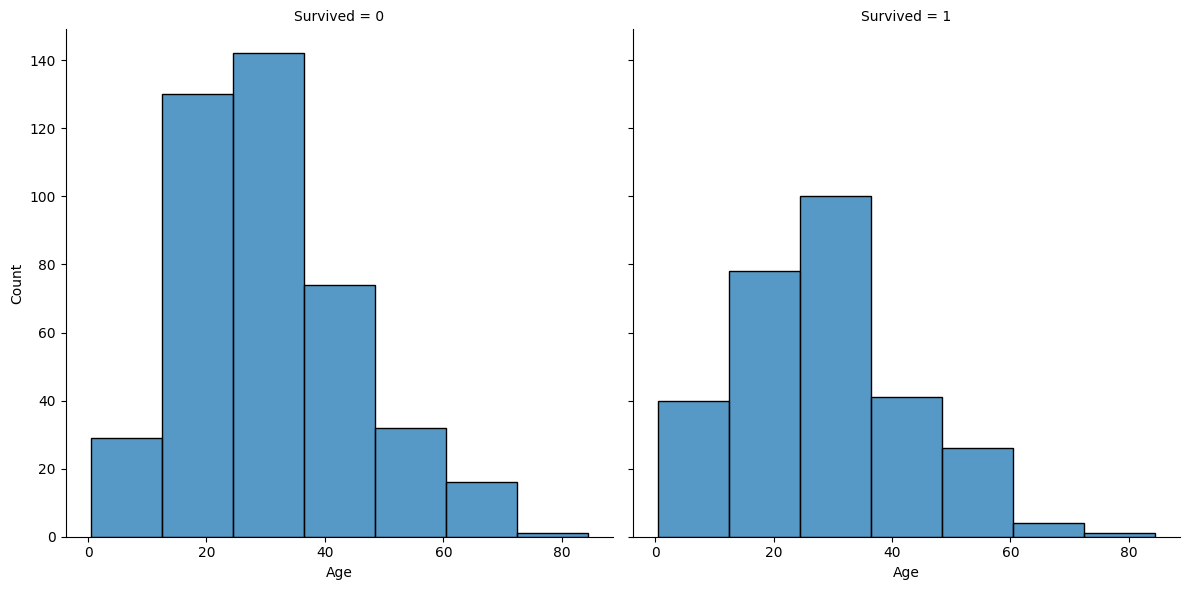

In [14]:
# distribution of the survived/non-survived and their age 
sns.displot(train, x = 'Age', col = 'Survived', binwidth = 12, height = 6)

- Quantile-based discretization:
    - divide the data into quantiles, which are intervals that contain an equal number of observations
    - then assign discrete labels to the original data based on these quantiles

In [15]:
train['Age_cut'] = pd.qcut(train['Age'], 8)
test['Age_cut'] = pd.qcut(test['Age'], 8)

In [16]:
train.groupby(['Age_cut'], as_index = False)['Survived'].mean()

,Age_cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


- Younger people (16-28) were less likely to survive, probably because of the class that they pertained to, since older people were more likely to pertain to the upper class.

- Classify ages with labels:

```
train.loc[train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 20) , 'Age'] = 1
train.loc[(train['Age'] > 20) & (train['Age'] <= 24) , 'Age'] = 2
train.loc[(train['Age'] > 24) & (train['Age'] <= 28) , 'Age'] = 3
train.loc[(train['Age'] > 28) & (train['Age'] <= 32) , 'Age'] = 4
train.loc[(train['Age'] > 32) & (train['Age'] <= 38) , 'Age'] = 5
train.loc[(train['Age'] > 38) & (train['Age'] <= 47) , 'Age'] = 6
train.loc[(train['Age'] > 47) & (train['Age'] <= 80) , 'Age'] = 7
```

- analogue for test

- Another way of assigning labels to the age group:

In [17]:
train['Age'] = pd.qcut( train['Age'], 8, labels = np.arange(8) + 1 )
test['Age'] = pd.qcut( test['Age'], 8, labels = np.arange(8) + 1 )

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_cut
0,1,0,3,"Braund, Mr. Owen Harris",male,3,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,6,1,0,PC 17599,71.2833,C85,C,2,Small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,4,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,6,1,0,113803,53.1000,C123,S,2,Small,"(32.312, 38.0]"
4,5,0,3,"Allen, Mr. William Henry",male,6,0,0,373450,8.0500,NaN,S,1,Alone,"(32.312, 38.0]"


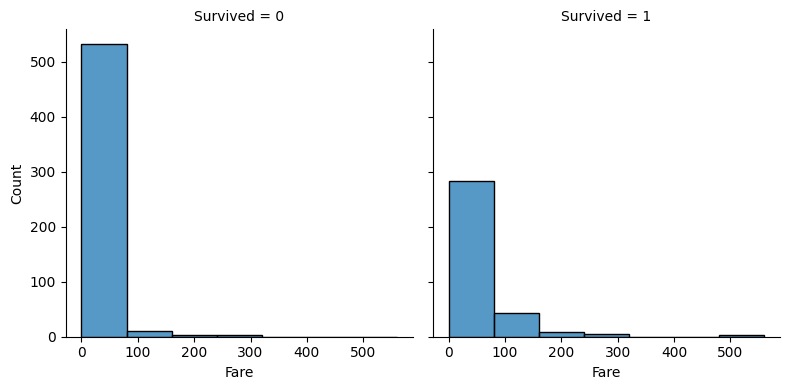

In [19]:
sns.displot(train, x = 'Fare', col = 'Survived', binwidth = 80, height = 4)

- The more expensive the ticket, the more likely the passenger was to survive, which makes sense since the upper class paid more.

In [20]:
train['Fare_cut'] = pd.qcut(train['Fare'], 6)
test['Fare_cut'] = pd.qcut(test['Fare'], 6)

In [21]:
train.groupby(['Fare_cut'], as_index = False)['Survived'].mean()

,Fare_cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


- a ticket price of >52$ meant a chance of ~70% of survival

In [22]:
train['Fare'] = pd.qcut( train['Fare'], 6, labels = np.arange(6) + 1 )
test['Fare'] = pd.qcut( test['Fare'], 6, labels = np.arange(6) + 1 )

In [23]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

- Find the title of a person:

In [24]:
# use expand to split the results in columns
# first step: train['Name'].str.split(pat = ',', expand = True)

train['Title'] = train['Name'].str.split(pat = ',', expand = True)[1].str.split(pat = '.', expand = True)[0].apply(lambda x: x.strip())
test['Title'] = test['Name'].str.split(pat = ',', expand = True)[1].str.split(pat = '.', expand = True)[0].apply(lambda x: x.strip())

In [25]:
train.groupby(['Title'], as_index = False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Capt,1,0.000000
1,Col,2,0.500000
2,Don,1,0.000000
3,Dr,7,0.428571
4,Jonkheer,1,0.000000
5,Lady,1,1.000000
6,Major,2,0.500000
7,Master,40,0.575000
8,Miss,182,0.697802
9,Mlle,2,1.000000


- military: Capt, Col, Major
- noble: Jonkheer, the Countess, Don, Lady, Sir
- unmaried Female: Mlle, Ms, Mme

In [26]:
train['Title'] = train['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Nobel',
    'the Countess': 'Nobel',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'
})

test['Title'] = test['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Nobel',
    'the Countess': 'Nobel',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'
})

In [27]:
train.groupby(['Title'], as_index = False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Nobel,2,0.500000
7,Noble,7,0.857143
8,Rev,6,0.000000


- Since the name length may be an indicator of the passenger's wealth:

In [28]:
train['Name_len'] = train['Name'].apply(lambda x: len(x))
test['Name_len'] = test['Name'].apply(lambda x: len(x))

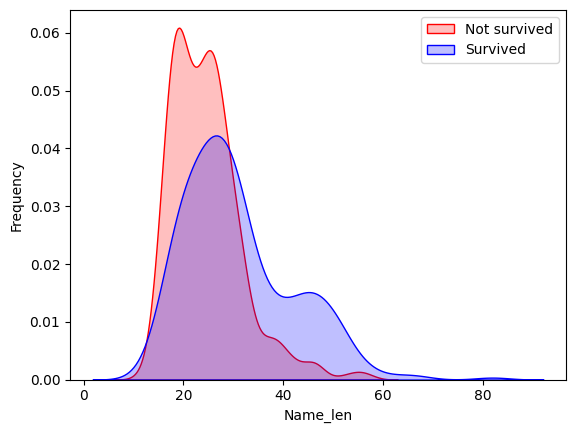

In [29]:
# select only the name lengths (Name_len) for passengers who did not survive (Survived == 0) and have a non-null name length
g = sns.kdeplot(train['Name_len'][(train['Survived'] == 0) & (train['Name_len'].notnull())], color = 'Red', fill = True)
g = sns.kdeplot(train['Name_len'][(train['Survived'] == 1) & (train['Name_len'].notnull())], color = 'Blue', fill = True)

g.set_xlabel('Name_len')
g.set_ylabel('Frequency')

g = g.legend(['Not survived', 'Survived'])

In [30]:
train['Name_len_grouped'] = pd.qcut(train['Name_len'], 3)
test['Name_len_grouped'] = pd.qcut(test['Name_len'], 3)

In [31]:
train.groupby(['Name_len_grouped'], as_index = False)['Survived'].mean()

,Name_len_grouped,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [32]:
train['Name_size'] = pd.qcut(train['Name_len'], 3, labels = np.arange(3) + 1 )
test['Name_size'] = pd.qcut(test['Name_len'], 3, labels = np.arange(3) + 1 )

In [33]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Family_size_grouped,Age_cut,Fare_cut,Title,Name_len,Name_len_grouped,Name_size
0,1,0,3,"Braund, Mr. Owen Harris",male,3,1,0,A/5 21171,1,NaN,S,2,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 28.0]",2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,6,1,0,PC 17599,6,C85,C,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(28.0, 82.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,4,0,0,STON/O2. 3101282,2,NaN,S,1,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(11.999, 22.0]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,6,1,0,113803,6,C123,S,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(28.0, 82.0]",3
4,5,0,3,"Allen, Mr. William Henry",male,6,0,0,373450,2,NaN,S,1,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 28.0]",2


- Look at the ticket:

In [34]:
train['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [35]:
# move backwards and get the ticket number 

train['TicketNo'] = train['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test['TicketNo'] = test['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [36]:
train.groupby(['TicketNo'], as_index = False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending = False)

,TicketNo,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


In [37]:
# group-wise count of occurrences for each unique value in the 'TicketNo' column
train.groupby('TicketNo')['TicketNo'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: TicketNo, Length: 891, dtype: int64

In [38]:
train['TicketNoCounts'] = train.groupby('TicketNo')['TicketNo'].transform('count')
test['TicketNoCounts'] = test.groupby('TicketNo')['TicketNo'].transform('count')

In [39]:
train.groupby(['TicketNoCounts'], as_index = False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending = False)

,TicketNoCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [40]:
train['Ticket'].str.split(pat = ' ', expand = True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [41]:
# make sure the '1' is not null and grab the value from the '0' column 
# if it's null, it will be set to blank
train['Ticket_Location'] = np.where(train['Ticket'].str.split(pat = ' ', expand = True)[1].notna(), 
                                    train['Ticket'].str.split(pat = ' ', expand = True)[0].apply(lambda x: x.strip()),
                                    'Blank')

test['Ticket_Location'] = np.where(test['Ticket'].str.split(pat=' ', expand=True)[1].notna(), 
                                   test['Ticket'].str.split(pat=' ', expand=True)[0].apply(lambda x: x.strip()), 
                                   'Blank')

In [42]:
train['Ticket_Location'].value_counts()

Ticket_Location
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

In [43]:
train['Ticket_Location'] = train['Ticket_Location'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

test['Ticket_Location'] = test['Ticket_Location'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [44]:
train.groupby(['Ticket_Location'], as_index = False)['Survived'].agg(['count', 'mean'])

,Ticket_Location,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


- Apparently the above idea didn't work but I will keep it since I researched it. So the effort matters, at least.

In [45]:
train['Cabin'] = train['Cabin'].fillna('U')
train['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train['Cabin']])

test['Cabin'] = test['Cabin'].fillna('U')
test['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test['Cabin']])

In [46]:
train.groupby(['Cabin'], as_index = False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


- Reduce the cabin's categories (known/not known = assigned/not assigned):

In [47]:
train['Cabin_Assigned'] = train['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test['Cabin_Assigned'] = test['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [48]:
train.groupby(['Cabin_Assigned'], as_index = False)['Survived'].agg(['count', 'mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [49]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_cut,Fare_cut,Title,Name_len,Name_len_grouped,Name_size,TicketNo,TicketNoCounts,Ticket_Location,Cabin_Assigned
0,1,0,3,"Braund, Mr. Owen Harris",male,3,1,0,A/5 21171,1,...,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(22.0, 28.0]",2,21171,1,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,6,1,0,PC 17599,6,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(28.0, 82.0]",3,17599,1,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,4,0,0,STON/O2. 3101282,2,...,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(11.999, 22.0]",1,3101282,1,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,6,1,0,113803,6,...,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(28.0, 82.0]",3,113803,2,Blank,1
4,5,0,3,"Allen, Mr. William Henry",male,6,0,0,373450,2,...,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(22.0, 28.0]",2,373450,1,Blank,0


In [50]:
print(train.shape, '\n')
print(test.shape)

(891, 24) 

(418, 23)


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    category
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    category
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_size          891 non-null    int64   
 13  Family_size_grouped  891 non-null    object  
 14  Age_cut              714 non-null    category
 15  Fare_cut             89

- There are some missing values that need to be handled.

In [52]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_size',
       'Family_size_grouped', 'Age_cut', 'Fare_cut', 'Title', 'Name_len',
       'Name_len_grouped', 'Name_size', 'TicketNo', 'TicketNoCounts',
       'Ticket_Location', 'Cabin_Assigned'],
      dtype='object')

In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    category
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    category
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_size          418 non-null    int64   
 12  Family_size_grouped  418 non-null    object  
 13  Age_cut              332 non-null    category
 14  Fare_cut             417 non-null    category
 15  Title                41

In [54]:
train['Age'] = train['Age'].astype(float)
test['Age'] = test['Age'].astype(float)

train['Name_size'] = train['Name_size'].astype(float)
test['Name_size'] = test['Name_size'].astype(float)

train['Fare'] = train['Fare'].astype(float)
test['Fare'] = test['Fare'].astype(float)

train['Age'].fillna(train['Age'].mean(), inplace=True)

test['Age'].fillna(test['Age'].mean(), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [55]:
onehot_encoder = OneHotEncoder(sparse_output=False) # sparse_output set to False to return a np array -> dense format
ordinal_encoder = OrdinalEncoder # ordinal rankingg
simple_imputer = SimpleImputer(strategy='most_frequent') # missing values 

ordinal_cols = ['Family_size_grouped']
onehot_cols = ['Sex', 'Embarked']

<Axes: >

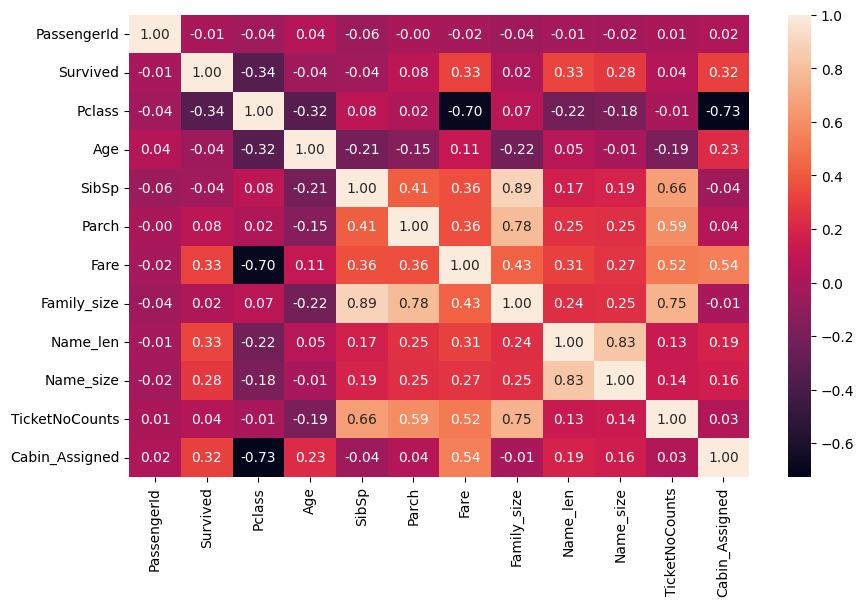

In [56]:
correlation_matrix = train.corr(numeric_only = True)
plt.figure(figsize=(10, 6)) 
sns.heatmap(correlation_matrix, annot =  True, fmt = ".2f")

In [57]:
X = train.drop(['Survived', 'SibSp', 'Parch'], axis = 1)
y = train['Survived']

X_test = test.drop(['Age_cut', 'Fare_cut', 'SibSp', 'Parch'], axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

    - stratify = y: ensures that the train and test sets have the same proportion of class labels as the original dataset y.
    - This is particularly useful for ensuring that both the training and testing datasets are representative of the overall distribution of the data, especially when dealing with imbalanced datasets where the class distribution is not uniform.

- Build the pipelines:

In [58]:
ordinal_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1))
])

onehot_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])


col_transformer = ColumnTransformer(transformers = [
    ('impute', simple_imputer, ['Age']),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('onehot_pipeline', onehot_pipeline, onehot_cols),
    ('passthrough', 'passthrough', ['Pclass', 'Cabin_Assigned', 'Name_size', 'Age', 'Fare', 'TicketNoCounts']) # mention the columns to be kept
    ],                   
    remainder = 'drop', # drop the columns that are not important
    n_jobs = -1)

- ColumnTransformer parameters: 
    - transformers: This is a list of tuples. Each tuple contains a name, a transformer, and a list of columns on which the transformer should be applied.
    - remainder: Specifies what to do with columns that are not explicitly selected by the transformers. The default is 'drop', which means that columns not specified in transformers are dropped. It can also be set to 'passthrough' for including the remaining columns in the output without transformation, or a transformer can be specified to apply a default transformation to the remaining columns.
    - n_jobs: The number of jobs to run in parallel for fitting and transforming. -1 means using all processors. This can speed up the fitting process when dealing with large datasets and multiple transformations.
    - Others:
        - sparse_threshold: This float sets the threshold for the output type. If the density of the transformed data is below this threshold, the transformed data will be returned as a sparse matrix. The default is 0.3; if more than 30% of the data is zeros, it will be a sparse matrix.
        - transformer_weights: Optional weights for multiplicative weighting of features transformed by the transformers. It assigns weights to each transformer's features in the output. This can be useful if some transformed features are more important than others.
        - verbose: Controls the verbosity; the higher, the more messages. Useful for debugging or when you want detailed outputs during fitting and transforming stages. (True/False)

- Build the models:

In [59]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [5, 10, 15],
    'max_depth': [8, 9, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_rfc = make_pipeline(col_transformer, cv_rfc)
pipe_final_rfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [8, 9, 10, 15, 20],
                                          'min_samples_leaf': [1, 3, 5],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [100, 150, 200]}))])

In [60]:
print(cv_rfc.best_params_, '\n')
print(cv_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200} 

0.8201713779178567


In [61]:
decision_tree = DecisionTreeClassifier()

param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

cv_decision_tree = GridSearchCV(estimator = decision_tree, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_decision_tree = make_pipeline(col_transformer, cv_decision_tree)
pipe_final_decision_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 20, 30, 40],
                                          'min_samples_leaf': [1, 3, 5],
                                          'min_samples_split': [5, 10, 15]}))])

In [62]:
print(cv_decision_tree.best_params_, '\n')
print(cv_decision_tree.best_score_)

{'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 3, 'min_samples_split': 5} 

0.8061755146262188


In [63]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12, 13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3]
}

cv_knn = GridSearchCV(estimator = knn, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_knn = make_pipeline(col_transformer, cv_knn)
pipe_final_knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 12, 13],
                                          'p': [1, 2, 3],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [64]:
print(cv_knn.best_params_, '\n')
print(cv_knn.best_score_)

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'} 

0.8006106569486852


In [65]:
svc = SVC(probability = True) # enable class probability estimates

param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
}

cv_svc = GridSearchCV(estimator = svc, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_svc = make_pipeline(col_transformer, cv_svc)
pipe_final_svc.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(probability=True),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']}))])

In [66]:
print(cv_svc.best_params_, '\n')
print(cv_svc.best_score_)

{'C': 10, 'kernel': 'rbf'} 

0.8061656653205949


In [67]:
log_reg =  LogisticRegression()

param_grid = {
    'C': [100, 10, 1.0, 0.2, 0.001]
}

cv_log_reg = GridSearchCV(estimator = log_reg, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_log_reg = make_pipeline(col_transformer, cv_log_reg)
pipe_final_log_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.2, 0.001]}))])

In [68]:
print(cv_log_reg.best_params_, '\n')
print(cv_log_reg.best_score_)

{'C': 0.2} 

0.8019600118191667


In [69]:
naive_bayes = GaussianNB()

param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001]
}

cv_naive_bayes = GridSearchCV(estimator = naive_bayes, param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

pipe_final_naive_bayes = make_pipeline(col_transformer, cv_naive_bayes)
pipe_final_naive_bayes.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_size_grouped']),
                                                 ('onehot_pipeline',
                                                  Pip...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_size', 'Age', 'Fare',
                                                   'TicketNoCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-08]}))])

In [70]:
print(cv_naive_bayes.best_params_, '\n')
print(cv_naive_bayes.best_score_)

{'var_smoothing': 1e-08} 

0.7781246922091992


In [71]:
Y_pred1 = pipe_final_rfc.predict(X_test)
Y_pred2 = pipe_final_decision_tree.predict(X_test)
Y_pred3 = pipe_final_knn.predict(X_test)
Y_pred4 = pipe_final_svc.predict(X_test)
Y_pred5 = pipe_final_log_reg.predict(X_test)
Y_pred6 = pipe_final_naive_bayes.predict(X_test)

In [72]:
submission1 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred1
})

submission2 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred2
})

submission3 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred3
})

submission4 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred4
})

submission5 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred5
})

submission6 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': Y_pred6
})

In [73]:
submission1.to_csv('/kaggle/working/submission_21_04_rfc.csv', index = False)
submission2.to_csv('/kaggle/working/submission_21_04_decision_tree.csv', index = False)
submission3.to_csv('/kaggle/working/submission_21_04_knn.csv', index = False)
submission4.to_csv('/kaggle/working/submission_21_04_svc.csv', index = False)
submission5.to_csv('/kaggle/working/submission_21_04_log_reg.csv', index = False)
submission6.to_csv('/kaggle/working/submission_21_04_naive_bayes.csv', index = False)